# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

We start by getting some statistics of the data

In [2]:
df.temperature.describe()

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64

**1.** To check for normality I’ll plot theand ecdf of the samples with ones produced from a normal distribution which have the same mean and variance

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

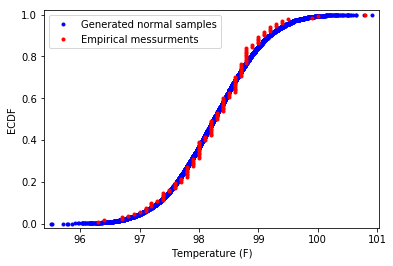

In [4]:
norm_temperature = np.random.normal(np.mean(df.temperature), np.std(df.temperature),10000)
edcf_norm = ECDF(norm_temperature)
ecdf_emp = ECDF(df.temperature)
plt.plot(edcf_norm.x, edcf_norm.y, marker='.', linestyle='none', color='blue')
plt.plot(ecdf_emp.x, ecdf_emp.y, marker='.', linestyle='none', color='red')
plt.xlabel('Temperature (F)')
plt.ylabel('ECDF')
plt.legend(['Generated normal samples', 'Empirical messurments'])
plt.margins(0.02)
plt.show()

It's hard to determine, some of the values seems off. But it's looking almost O.k. 

let’s try a Q-Q plot

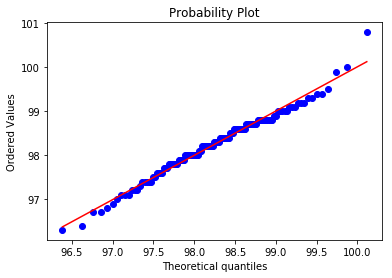

In [5]:
from scipy import stats
stats.probplot(df.temperature, dist='norm', sparams=(np.mean(df.temperature), np.std(df.temperature)), plot=plt)
plt.show()

This seems sort of O.k. I'm assuming we were just unlucky enough to get an outlier (if I was part of the test sample they would have gotten an insane outlier at the other side as I have the normal body temperature of a corpse)

Let's try some non-graphical methods, starting with: Back-of-the-envelope test

In [6]:
max_in_std = (np.max(df.temperature)-np.mean(df.temperature))/np.std(df.temperature)
min_in_std = (np.mean(df.temperature) -np.min(df.temperature))/np.std(df.temperature)
print('maximum distance form mean (in STD): {} \
      \nminimum distance form mean (in STD): {}'.format(max_in_std,min_in_std))

maximum distance form mean (in STD): 3.4924927267747696       
minimum distance form mean (in STD): 2.6688711006174173


The maximum distance from the mean is larger than $3\hat{\sigma}$, which for this small sample should be alarming, but we already knew that, so we will continue assuming its normal. 
Just to be fancy, let’s try Kolmogorov-Smirnov test:

In [7]:
_, p_value = stats.kstest(df.temperature, cdf='norm')
print('Sample is normal with p-value:{:1.3}'.format(p_value))

Sample is normal with p-value:0.0


*This seems reassuring*

**2.** It's hard to judge the sample size, it’s all depends on the confidence intervals we require. I personally would have liked a bigger sample that would convince me of the normality as it is fairly easy to get temperature measurements. Assuming that the samples are from different individuals they are supposed to be independent.

**3.** Checking the (null) hypothesis that the mean is 98.6 degrees F

Starting with bootstrapping:

In [8]:
#shifting the empirical ditribution to have a mean of 98.6
test_mean = 98.6
sample_mean = np.mean(df.temperature)
shifted_temp = df.temperature.values - sample_mean + test_mean
# Generating bootstrap samples
num_tests = 100000
bs_means = np.empty(num_tests)
for i in range(num_tests):
    bs_means[i] = np.mean(np.random.choice(shifted_temp, size=len(shifted_temp)))
p_val = sum(bs_means <= sample_mean)/num_tests
print('p-value: {:1.3e} (fraction of replicates with mean difference from 98.2 as the sample mean)'.format(p_val))

p-value: 0.000e+00 (fraction of replicates with mean difference from 98.2 as the sample mean)


So, according to the bootstrap test reject accept the hypothesis. (the p value is not actually zero, just very small so we never generated any sample which matches the hypothesis)
Now trying frequentist statistical testing. I will use a one sample test, as there is only one sample we draw from, and we are not comparing between two samples. We do not know the population $\sigma$ so we will use a $t$ test

In [9]:
#unbiased estimator for the std
from scipy import stats
sigma_hat = np.std(df.temperature, ddof=1)
t = (test_mean - sample_mean)/(sigma_hat/np.sqrt(len(df.temperature)))
p_val= 1- stats.t.cdf(t, len(df.temperature))
print('p-value: {:2.2e}'.format(p_val))

p-value: 1.19e-07


We don’t know the population $\sigma$ so I'm not sure how to perform a $z$ test, but I'll try with $\hat{\sigma}$

In [10]:
p_val= 1- stats.norm.cdf(t)
print('p-value: {:2.2e}'.format(p_val))

p-value: 2.45e-08


**4.** Choosing a random **n**=10 sample an repeating the tests:

In [11]:
random_sample = np.random.choice(df.temperature,10, replace=False)
sigma_hat = np.std(random_sample, ddof=1)
t = (test_mean - np.mean(random_sample))/(sigma_hat/np.sqrt(len(random_sample)))
p_val= 1- stats.t.cdf(t, len(random_sample))
print('p-value: {:2.2}'.format(p_val))

p-value: 0.0025


In [12]:
p_val= 1- stats.norm.cdf(t)
print('p-value: {:2.2}'.format(p_val))

p-value: 0.00017


The p-values varies depends on the random sample chosen. It is obvious that the Z test gives a lower p-value (as the tails are decaying faster). At this sample size, even if the population $\sigma$ is knows I would have used the t-test

**5** What is a considered a normal temperature 

We start by bootstrapping a confidence interval for a single measurement
If a measurement is within the 2.5 and 97.5 percentiles it will be considered normal. This is not extremely accurate and the values we'll get will be limited to measurements in the sample group.

In [13]:
num_tests = 10000
bs_messure = np.empty(num_tests)
for i in range(num_tests):
    bs_messure[i] = np.mean(np.random.choice(df.temperature, 1))
confidance = np.percentile(bs_messure, [2.5,97.5]) 
print('With a confidence of 95% normal temperature will fall in the range {}-{}'.format(confidance[0],confidance[1]))

With a confidence of 95% normal temperature will fall in the range 96.7-99.5


I'm not really sure how to do this with a frequentist statistical testing. I can presumable get a confidence interval for the mean using a t-test and a confidence interval for $\sigma$ using a $\chi^2$ test, then take 95% upper and lower limit and get a confidence interval again from a z-test. But this is really not a very accurate method. 

Maybe I'll just assume that the population is normally distributed with $\hat\mu=\mu$ and $\hat\sigma=\sigma$, which is kind of wrong but it’s easier.

$Z$-test

In [14]:
sigma_hat = np.std(df.temperature, ddof=1)
sigma_n = (sigma_hat)#/np.sqrt(len(df.temperature)))
# getting 2.5% margin level on both sides
n_conf = stats.norm.ppf(1-0.025, 1)
print('With a confidence of 95% normal temperature will fall in the range {:2.1f}-{:2.1f}'.format(
    sample_mean-n_conf*sigma_n,sample_mean+n_conf*sigma_n))

With a confidence of 95% normal temperature will fall in the range 96.1-100.4


**6.** Checking whether there is a significant difference between the temperature of males and females

We start with a bootstrap permutation test, which assumes nothing about the distributions

In [15]:
male_temp = df[df.gender =='M'].temperature
female_temp = df[df.gender =='F'].temperature
empirical_mean_diff = np.mean(female_temp) - np.mean(male_temp)

In [16]:
empirical_mean_diff

0.289230769230727

Permutation test

In [17]:
num_tests = 10000
bs_mean_diff = np.empty(num_tests)
males = len(male_temp)
for i in range(num_tests):
    permute_sample = np.random.permutation(df.temperature.values)
    bs_male_temp = permute_sample[0:males]
    bs_female_temp = permute_sample[males:]
    bs_mean_diff[i] = np.mean(bs_female_temp) - np.mean(bs_male_temp)

p_val = np.sum(bs_mean_diff >= empirical_mean_diff)/num_tests
print('p-value: {:1.2e}'.format(p_val))

p-value: 1.09e-02


And a frequentists approach, a two sample t-test is appropriate here, as we have two samples and we do not know the population mean

In [18]:
_, p_al = stats.ttest_ind(female_temp,male_temp)
print('p-value: {:1.2e}'.format(p_val))

p-value: 1.09e-02


This is a two-sided t-test, which accounts for the difference from the permutation test. Both are indicating there is a significant difference between the body temperatures of males and females

## Conclusion

While my test statistics indicate the mean temperature of the sample group are lower then the believed mean of 98.6 F, this is the strongest conclusion I can reach based on the data. I do not know how the data was collected, and there are many more variables which can influence the body temperature of an individual, for example we seen that for that group gender affects the mean body temperature and I imagine that the geographic origin and age can also play a role. That said the significant difference seems promising and calls for further study.
It is also observed that for this group female body temperature is higher than that of males.

As the table also have hear rate messurments I was windering if it is correlated with the bodey temperature

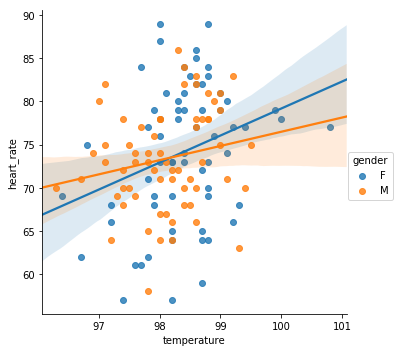

In [19]:
sns.lmplot(x='temperature', y='heart_rate', data=df, hue='gender')
plt.show()

There seems to be a slight correlation (especially at the extremes) but I don’t really sure if this is meaningful, the correlation seems to be higer for females. We can also see that males have slightly higher body temperature on average

In [20]:
pearson_r, _ =stats.pearsonr(df.temperature, df.heart_rate)
print('pearson r = {:1.3}'.format(pearson_r))

pearson r = 0.254


The correlation coefficient is pretty small, but posetive.